# Comparing sensitive vs resistant HGSC RNA-seq data to known mechanisms of resistant

## Introduction

Goal: to see which, if any, of the known mechanisms of resistance have highly differential activity between resistant and non-resistant HGSC cell lines.

Data on known mechanisms of resistance from https://www.nature.com/articles/s41388-021-02055-2#Sec39 Supplemental Table 1

Use `jupyter nbconvert --to html prev_literature_resistance_mechanisms.ipynb` to export notebook to a `.html` file

## Inputs

- Up and downregulated gene lists [using the deseq data categorically comparing sensitive and resistant]
- Metadata table
  
### Imports

In [1]:
import pandas as pd
from IPython.display import display
import math
import plotnine as p9
import numpy as np
from adjustText import adjust_text
from collections import Counter
import warnings

In [2]:
known_mechanisms_excel_file = "prev_literature_pt_resistance_genes.xlsx"
known_mechanism_groups_excel_file = (
    "prev_literature_resistance_mechanisms_groupings.xlsx"
)
differential_rnaseq_file = "../../../data/deseq/output/DESeq_HGSC.csv"

## Read in known mechanisms of platinum resistance

From documentation of table sourcing data:
- a) possible mechanism related to resistance
- b) notes from cited papers
- c) whether gene expression is up or downregulated in pt-resistant cells/tissues
- d) whether an up/down regulation of the gene promotes platinum resistance
- e) whether an exposure to platinum treatment upregulates or downregulates gene expression
- f) target of an approved drug
- g) score is strength of evidence

In [3]:
known_mechanisms_raw = pd.read_excel(known_mechanisms_excel_file)
# display(known_mechanisms_raw)

known_mechanisms = known_mechanisms_raw.copy()
known_mechanisms = known_mechanisms.rename(
    columns={
        "HUGO Gene symbol": "gene",
        "Putative mechanism associated with Pt-resistancea": "mechanisms",
        "Up / down in Pt-resistant cellsc": "dir_correlated_to_resistance",
        "Up / down to promote Pt-resistanced": "dir_causal_to_resistance",
        "Up / down after Pt-treatmente": "dir_after_treatment",
        "Druggablef": "druggable",
        "Scores": "score",
    }
)

known_mechanisms = known_mechanisms[
    [
        "gene",
        "mechanisms",
        "dir_correlated_to_resistance",
        "dir_causal_to_resistance",
        "dir_after_treatment",
        "druggable",
        "score",
    ]
]

# Split each row with multiple mechanisms into multiple rows each with one mechanism
known_mechanisms = (
    known_mechanisms.assign(mechanisms=known_mechanisms.mechanisms.str.split(", "))
    .explode("mechanisms")
    .reset_index(drop=True)
)

# Assign the direction of gene expression for resistance based on dir_correlated_to_resistance and dir_causal_to_resistance
for row in known_mechanisms.itertuples():
    up_found = (
        "UP" in row.dir_correlated_to_resistance or "UP" in row.dir_causal_to_resistance
    )
    down_found = (
        "DOWN" in row.dir_correlated_to_resistance
        or "DOWN" in row.dir_causal_to_resistance
    )
    dir = "UNKNOWN"

    if up_found and not down_found:
        dir = "UP"
    elif down_found and not up_found:
        dir = "DOWN"

    known_mechanisms.at[row.Index, "dir"] = dir

display(known_mechanisms)

,gene,mechanisms,dir_correlated_to_resistance,dir_causal_to_resistance,dir_after_treatment,druggable,score,dir
0,AATF,Apoptotic signaling,UP,UP,UP,NaN,1,UP
1,AATF,DDR,UP,UP,UP,NaN,1,UP
2,AATF,p53 signaling,UP,UP,UP,NaN,1,UP
3,ABCA8,Platinum efflux,UP,UP,UP,NaN,1,UP
4,ABCB1,Platinum efflux,UP,UP,UNCHANGED in S; UP in R,Yes,4,UP
...,...,...,...,...,...,...,...,...
1859,ZNF143,Apoptotic signaling,UP,UP,UNKNOWN,NaN,1,UP
1860,ZNF143,DDR,UP,UP,UNKNOWN,NaN,1,UP
1861,ZNF143,Transcription,UP,UP,UNKNOWN,NaN,1,UP
1862,ZNF93,MYC signaling,UP,UP,UNKNOWN,NaN,1,UP


### Categorize known mechanisms into 7 main groups

Groupings defined by Jessi, largely influenced by paper giving known mechanisms

In [4]:
known_mechanism_groups = pd.read_excel(known_mechanism_groups_excel_file)
known_mechanisms["group"] = ""

for index, row in known_mechanisms.iterrows():
    belongs_to_groups = []
    for group in known_mechanism_groups.columns:
        if row.mechanisms in known_mechanism_groups[group].values:
            belongs_to_groups.append(group)
    if len(belongs_to_groups) > 0:
        known_mechanisms.at[index, "group"] = "; ".join(belongs_to_groups)

# Remove mechanisms not assigned a group (i.e., "bystander affect")
known_mechanisms = known_mechanisms[known_mechanisms["group"] != ""].reset_index(
    drop=True
)

# Split each row with multiple groups into multiple rows each with one group
known_mechanisms = (
    known_mechanisms.assign(group=known_mechanisms.group.str.split("; "))
    .explode("group")
    .reset_index(drop=True)
)
display(known_mechanisms)

,gene,mechanisms,dir_correlated_to_resistance,dir_causal_to_resistance,dir_after_treatment,druggable,score,dir,group
0,AATF,Apoptotic signaling,UP,UP,UP,NaN,1,UP,"Inhibition of apoptotic signaling, downregulat..."
1,AATF,DDR,UP,UP,UP,NaN,1,UP,Enhanced repair and tolerance of platinum indu...
2,AATF,p53 signaling,UP,UP,UP,NaN,1,UP,Enhanced repair and tolerance of platinum indu...
3,ABCA8,Platinum efflux,UP,UP,UP,NaN,1,UP,"Reduced importation and increased exportation,..."
4,ABCB1,Platinum efflux,UP,UP,UNCHANGED in S; UP in R,Yes,4,UP,"Reduced importation and increased exportation,..."
...,...,...,...,...,...,...,...,...,...
1858,ZNF143,Apoptotic signaling,UP,UP,UNKNOWN,NaN,1,UP,"Inhibition of apoptotic signaling, downregulat..."
1859,ZNF143,DDR,UP,UP,UNKNOWN,NaN,1,UP,Enhanced repair and tolerance of platinum indu...
1860,ZNF143,Transcription,UP,UP,UNKNOWN,NaN,1,UP,Upregulation of key signaling pathways promoti...
1861,ZNF93,MYC signaling,UP,UP,UNKNOWN,NaN,1,UP,Upregulation of key signaling pathways promoti...


### Display all known mechanisms

In [5]:
# Count the occurrences of each mechanism
mechanism_counts = Counter(known_mechanisms["mechanisms"])

# Convert the mechanism counts to a DataFrame
mechanism_counts_df = (
    pd.DataFrame(list(mechanism_counts.items()), columns=["mechanism", "num_genes"])
    .sort_values(by="num_genes", ascending=False)
    .reset_index(drop=True)
)

# Display the DataFrame with mechanism counts
display(mechanism_counts_df)
print(mechanism_counts_df["mechanism"].tolist())

,mechanism,num_genes
0,Apoptotic signaling,106
1,ECM signaling,94
2,Immune response,93
3,CSC,83
4,EMT,71
...,...,...
78,exocytosis,1
79,Metabolism/cholesterol,1
80,mitochondria/DNA,1
81,OXPHOS,1


['Apoptotic signaling', 'ECM signaling', 'Immune response', 'CSC', 'EMT', 'DDR/HR', 'Cell cycle', 'Redox', 'Oncogene signaling', 'DDR', 'WNT signaling', 'NF-kB signaling', 'p53 signaling', 'Oncogene signaling/AKT', 'Platinum efflux', 'Transcription', 'Autophagy', 'Oncogene signaling/MAPK', 'Apoptosis', 'TGF-β signaling', 'Redox/Glutathione', 'Hypoxia signaling', 'DDR/NER', 'Oncogene signaling/EGFR', 'Metabolism/OXPHOS', 'Platinum uptake', 'DDR/FA', 'Translation', 'Transcription/Epigenetics', 'RNA processing', 'PKA signaling', 'mTOR signaling', 'Hippo signaling', 'Apoptotic signaling/MAPK', 'ubiquitin', 'ER stress response', 'Metabolism/Glycolysis', 'AMPK signaling', 'Chaperone', 'DDR/BER', 'DDR/nucleotide synthesis', 'Notch signaling', 'DDR/NHEJ', 'Apoptotic signaling/DR', 'Metabolism/Lipid', 'MYC signaling', 'Calcium signaling', 'DDR/TLS', 'DDR/DNA replication', 'Detox', 'Hedgehog signaling', 'pH/Pt-toxicity', 'DDR/MMR', 'Metabolism/amino acid', 'Oncogene signaling/VEGF', 'Metabolism/

## Display all known groups of mechanisms

In [6]:
# Count the occurrences of each group
group_counts = Counter(known_mechanisms["group"])

# Convert the group counts to a DataFrame
group_counts_df = pd.DataFrame(
    list(group_counts.items()), columns=["group of mechanisms", "num_genes"]
).sort_values(by="num_genes", ascending=False).reset_index(drop = True)

# Display the DataFrame with group counts
display(group_counts_df)

,group of mechanisms,num_genes
0,Upregulation of key signaling pathways promoti...,641
1,Enhanced repair and tolerance of platinum indu...,368
2,"Inhibition of apoptotic signaling, downregulat...",329
3,Extracellular mechanisms that alter the extrac...,263
4,"Reduced importation and increased exportation,...",98
5,Metabolic reprogramming,85
6,Hypoxia and other stress responses (e.g. ER st...,79


## Volcano plot for each group of mechanisms

In [25]:
# Volcano plot for a given mechanism group
def volcano_plot_mechanism(group, deseq_df, y_min, y_max, x_min, x_max):

    # Keep only the genes that are in the group of mechanisms of interest
    relevant_genes = known_mechanisms[known_mechanisms.group == group].gene
    volcano_plot_data = deseq_df[
        deseq_df.index.isin(relevant_genes)
    ]

    # Format plot data
    volcano_plot_data = volcano_plot_data.dropna(subset=["padj", "log2FoldChange"])
    volcano_plot_data["gene"] = volcano_plot_data.index
    volcano_plot_data["-log10padj"] = -np.log10(volcano_plot_data["padj"])
    volcano_plot_data = volcano_plot_data[["-log10padj", "log2FoldChange", "gene"]]
    # set score based on score in known_mechanisms
    volcano_plot_data["score (importance to mechanism)"] = volcano_plot_data[
        "gene"
    ].apply(lambda x: known_mechanisms[known_mechanisms["gene"] == x].score.values[0])
    # set direction based on dir in known_mechanisms
    volcano_plot_data["dir"] = volcano_plot_data["gene"].apply(
        lambda x: known_mechanisms[known_mechanisms["gene"] == x].dir.values[0]
    )
    # set with/against resistance based on dir and actual direction of change
    def with_against_resistance(row):
        if row["dir"] == "UP" and row["log2FoldChange"] > 0:
            return "WITH"
        elif row["dir"] == "UP" and row["log2FoldChange"] < 0:
            return "AGAINST"
        elif row["dir"] == "DOWN" and row["log2FoldChange"] < 0:
            return "WITH"
        elif row["dir"] == "DOWN" and row["log2FoldChange"] > 0:
            return "AGAINST"
        else:
            return "UNKNOWN"
    volcano_plot_data["with/against resistance"] = volcano_plot_data.apply(
        lambda row: with_against_resistance(row), axis=1
    )

    # Plot
    plot = (
        p9.ggplot(
            volcano_plot_data,
            p9.aes(
                x="log2FoldChange",
                y="-log10padj",
                color="with/against resistance",
                size="score (importance to mechanism)",
                label="gene",
            ),
        )
        + p9.geom_point(alpha=0.5)
        + p9.scale_color_manual(
            values={"WITH": "green", "AGAINST": "red", "UNKNOWN": "gray"}
        )
        + p9.geom_text(nudge_x=0.4)
        + p9.scale_size_continuous(range=[2.5, 5])
        + p9.theme_bw()
        + p9.theme(
            figure_size=(8, 8),
        )
        + p9.labs(
            x="log2 fold change",
            y="-log10 adjusted p-value",
            title=f"Volcano plot for genes related to \n{group} \nin resistant vs sensitive HGSC cell lines",
        )
        + p9.geom_vline(xintercept=-1.2, linetype="dashed", color="gray")
        + p9.geom_vline(xintercept=+1.2, linetype="dashed", color="gray")
        + p9.geom_hline(yintercept=1.301, linetype="dashed", color="gray")
        + p9.xlim(x_min, x_max)
        + p9.ylim(y_min, y_max)
    )
    display(plot)

Note: Green indicates that the regulation we saw is in the same direction as the regulation known to be correlated with resistance. Red indicates that the regulation we saw is opposite the direction known to be correlated with resistance. Gray is when there is conflicting evidence or it is otherwise unclear whether the gene being up or downregulated is known to be correlated with resistance. So, if a resistant cellline's mechanism closely follows a known mechanism, we would expect the plot to have mostly green points.

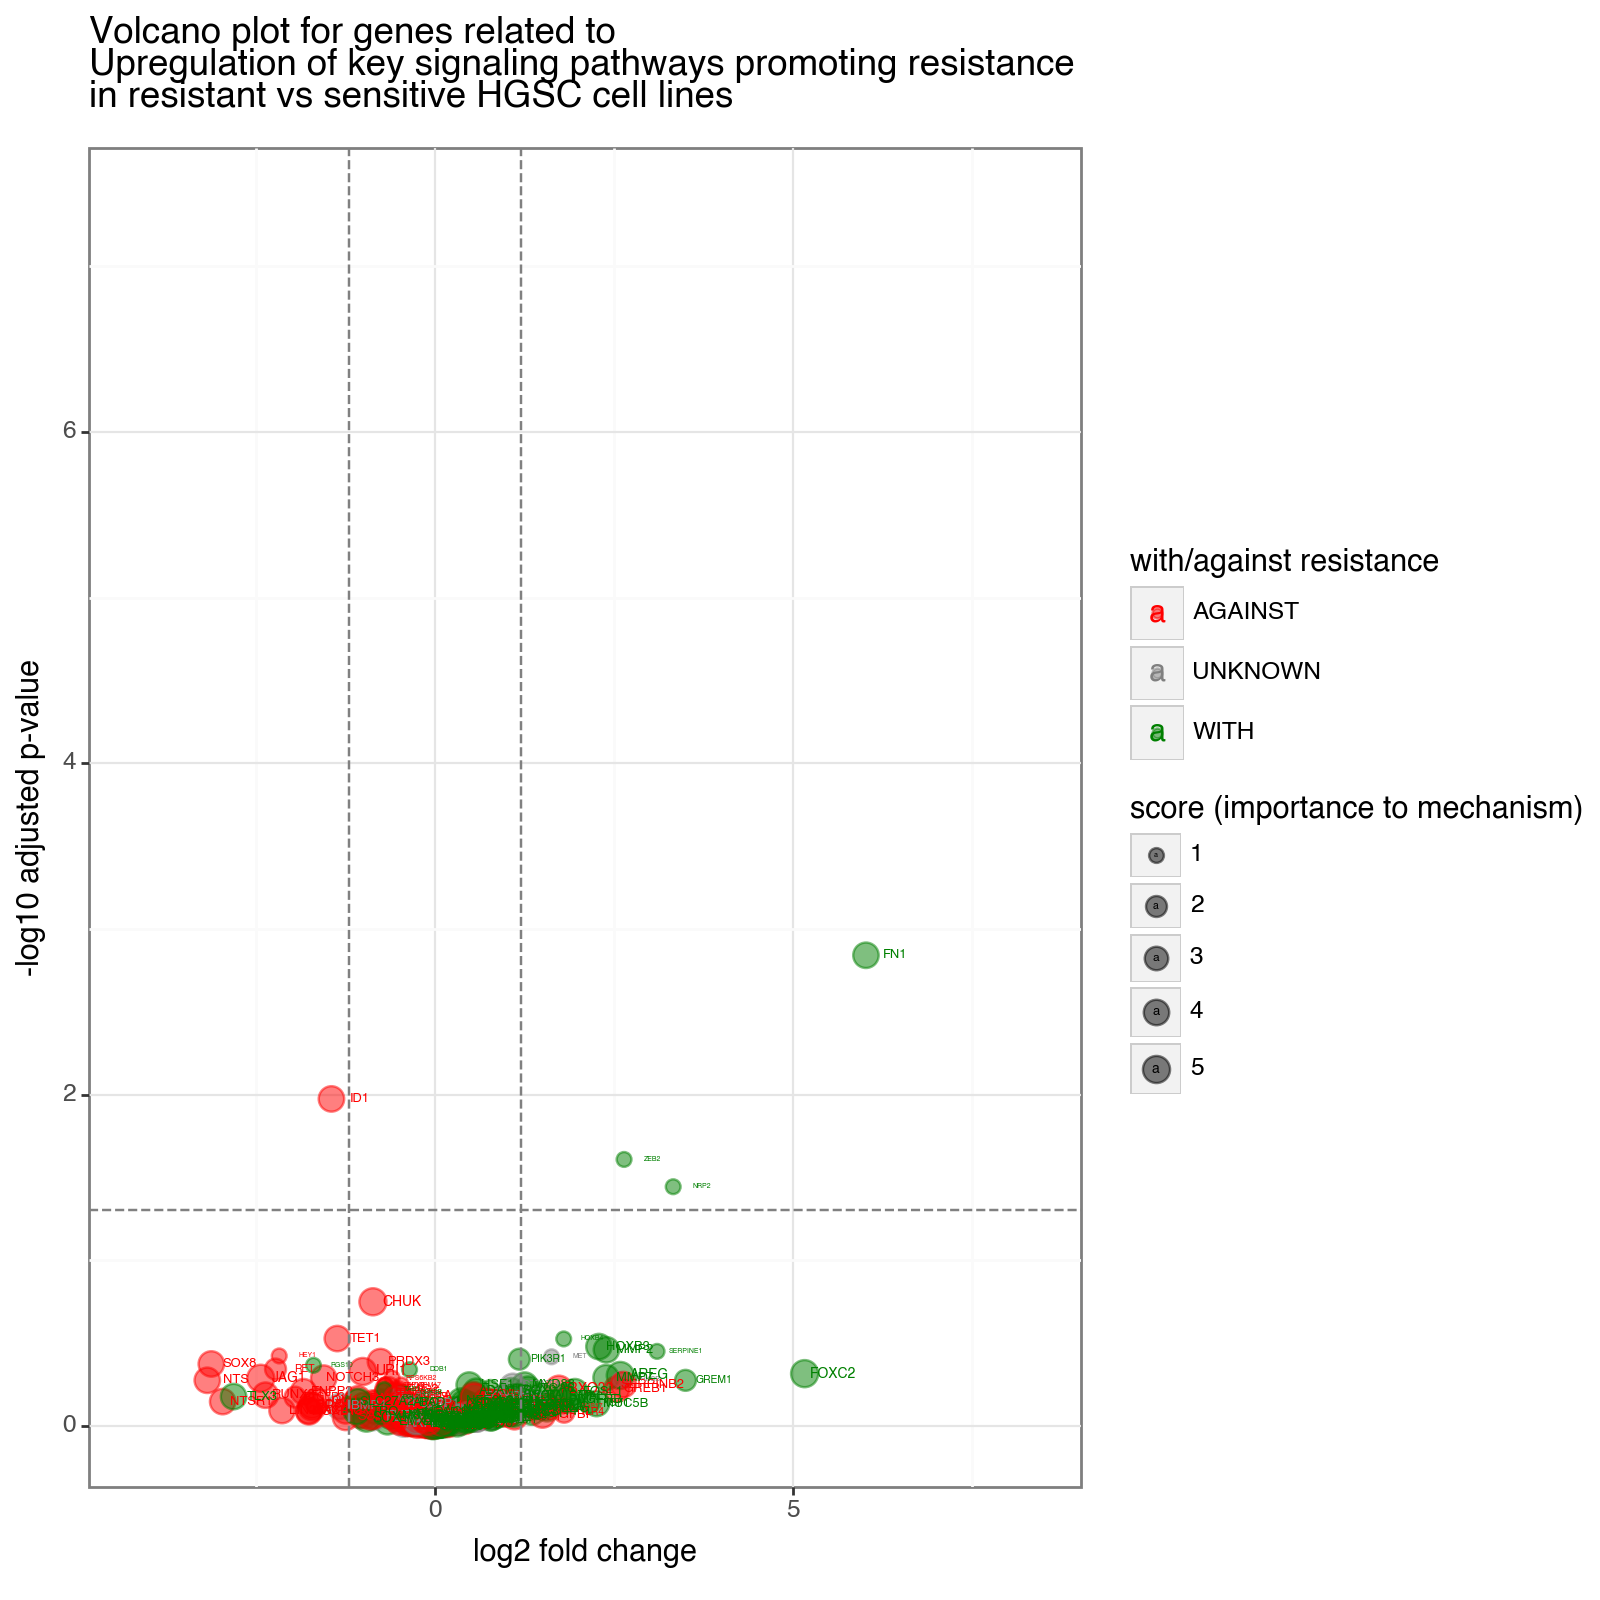

<Figure Size: (800 x 800)>

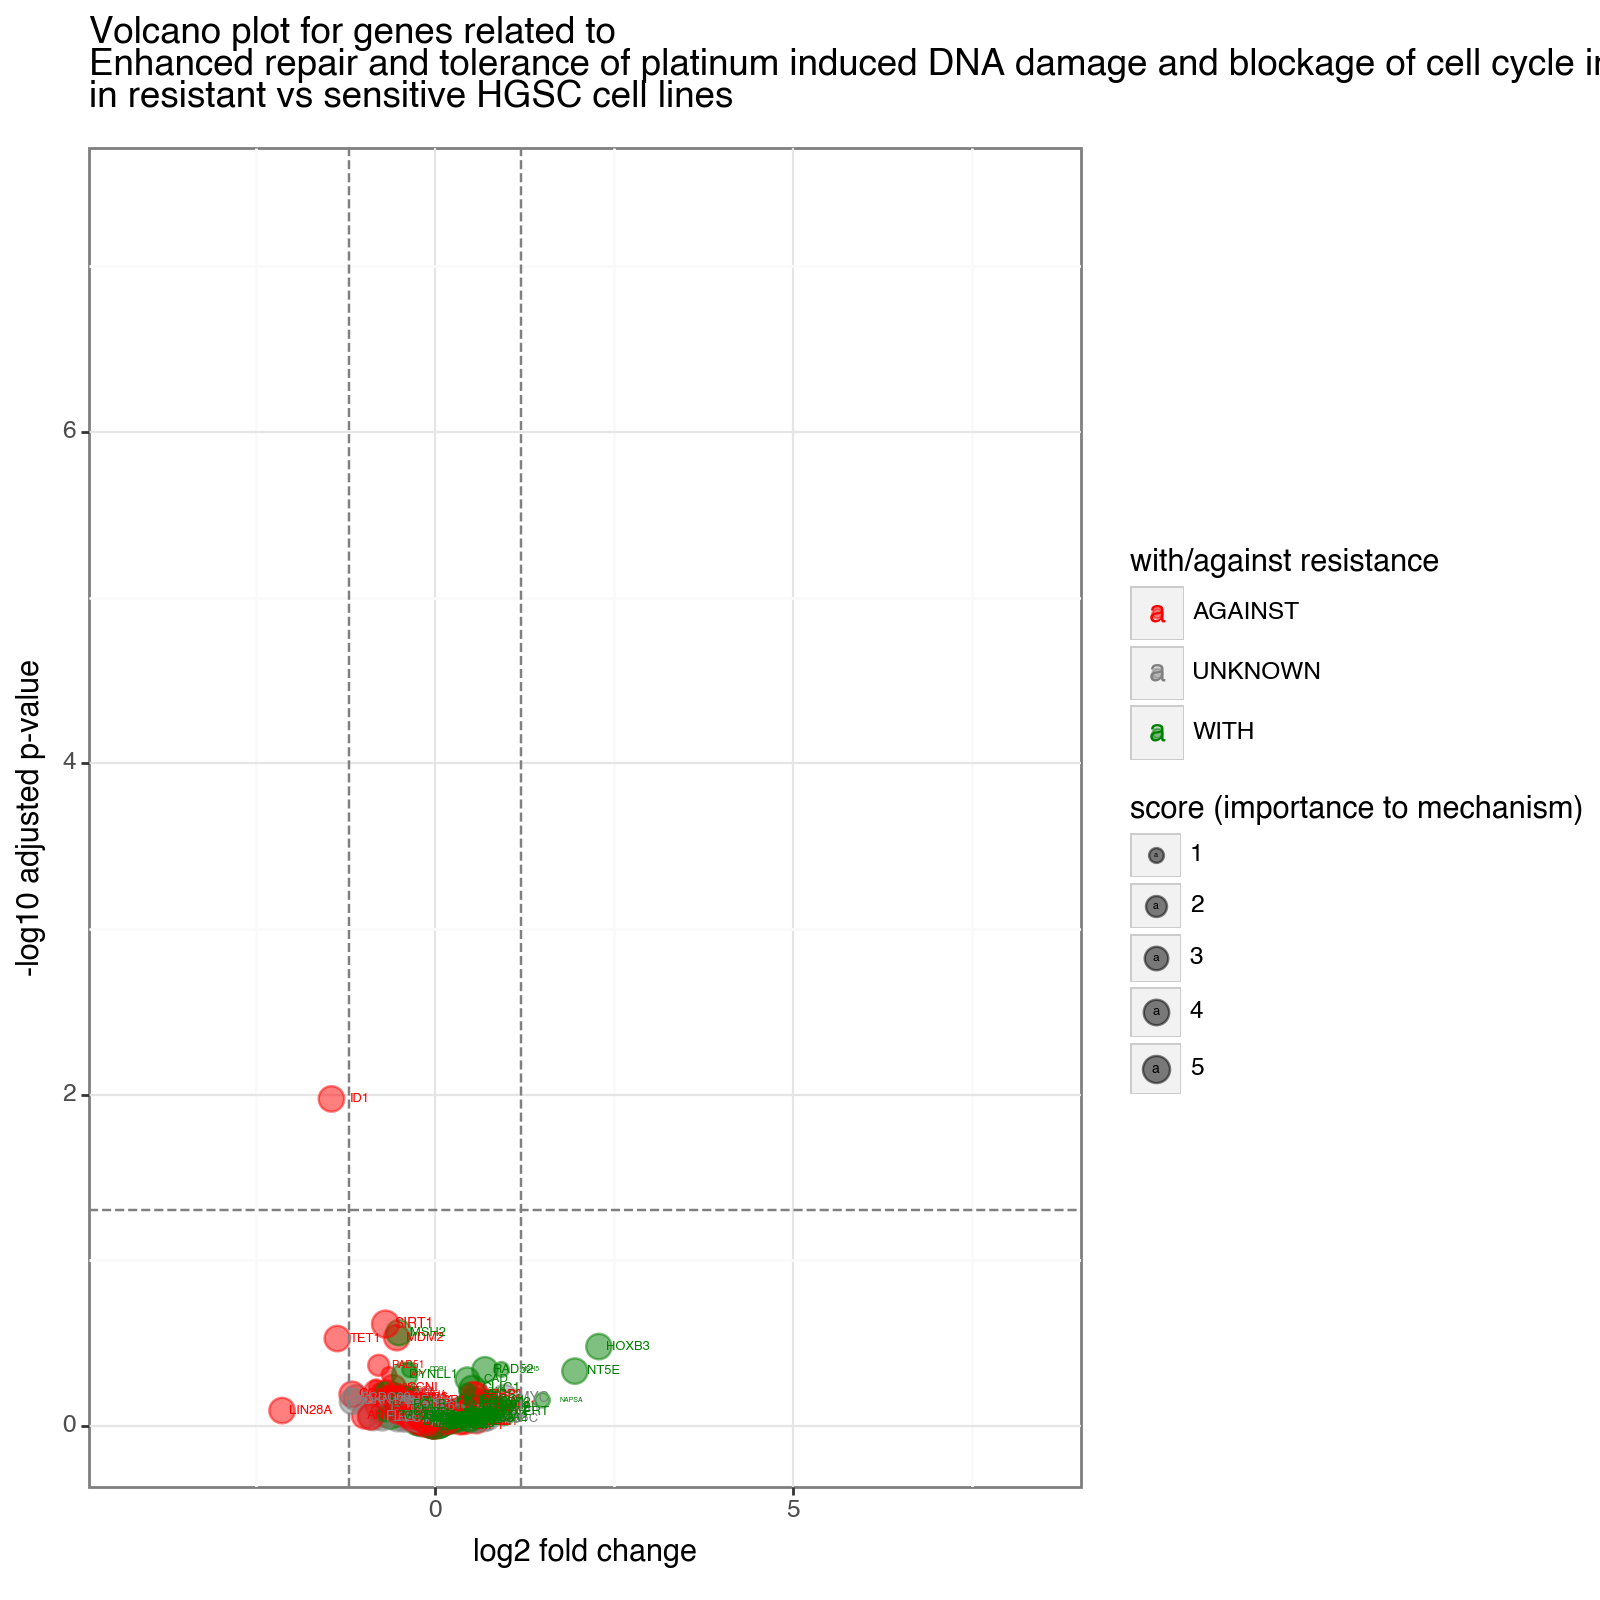

<Figure Size: (800 x 800)>

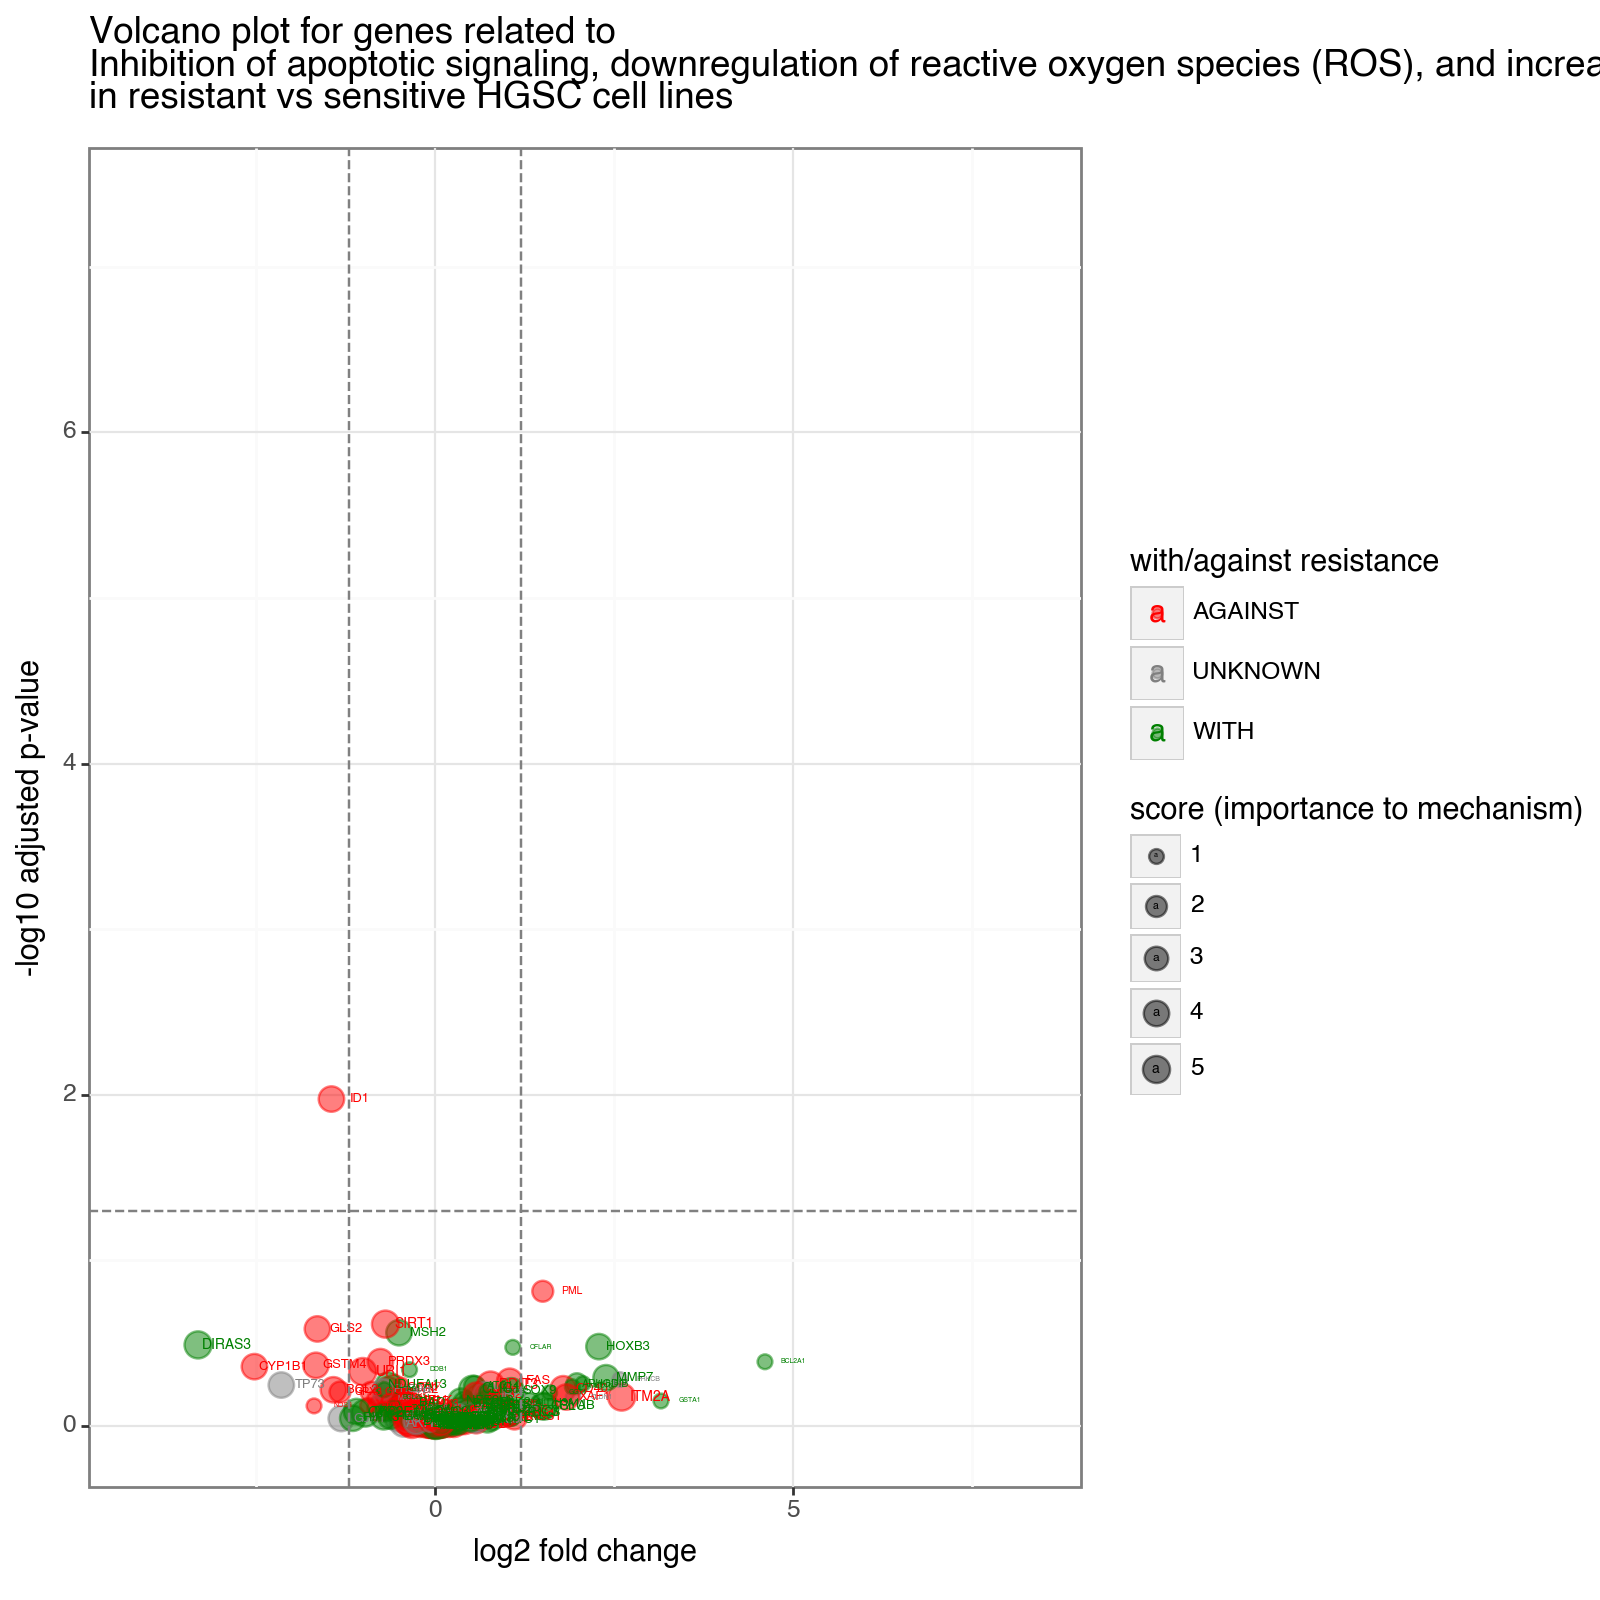

<Figure Size: (800 x 800)>

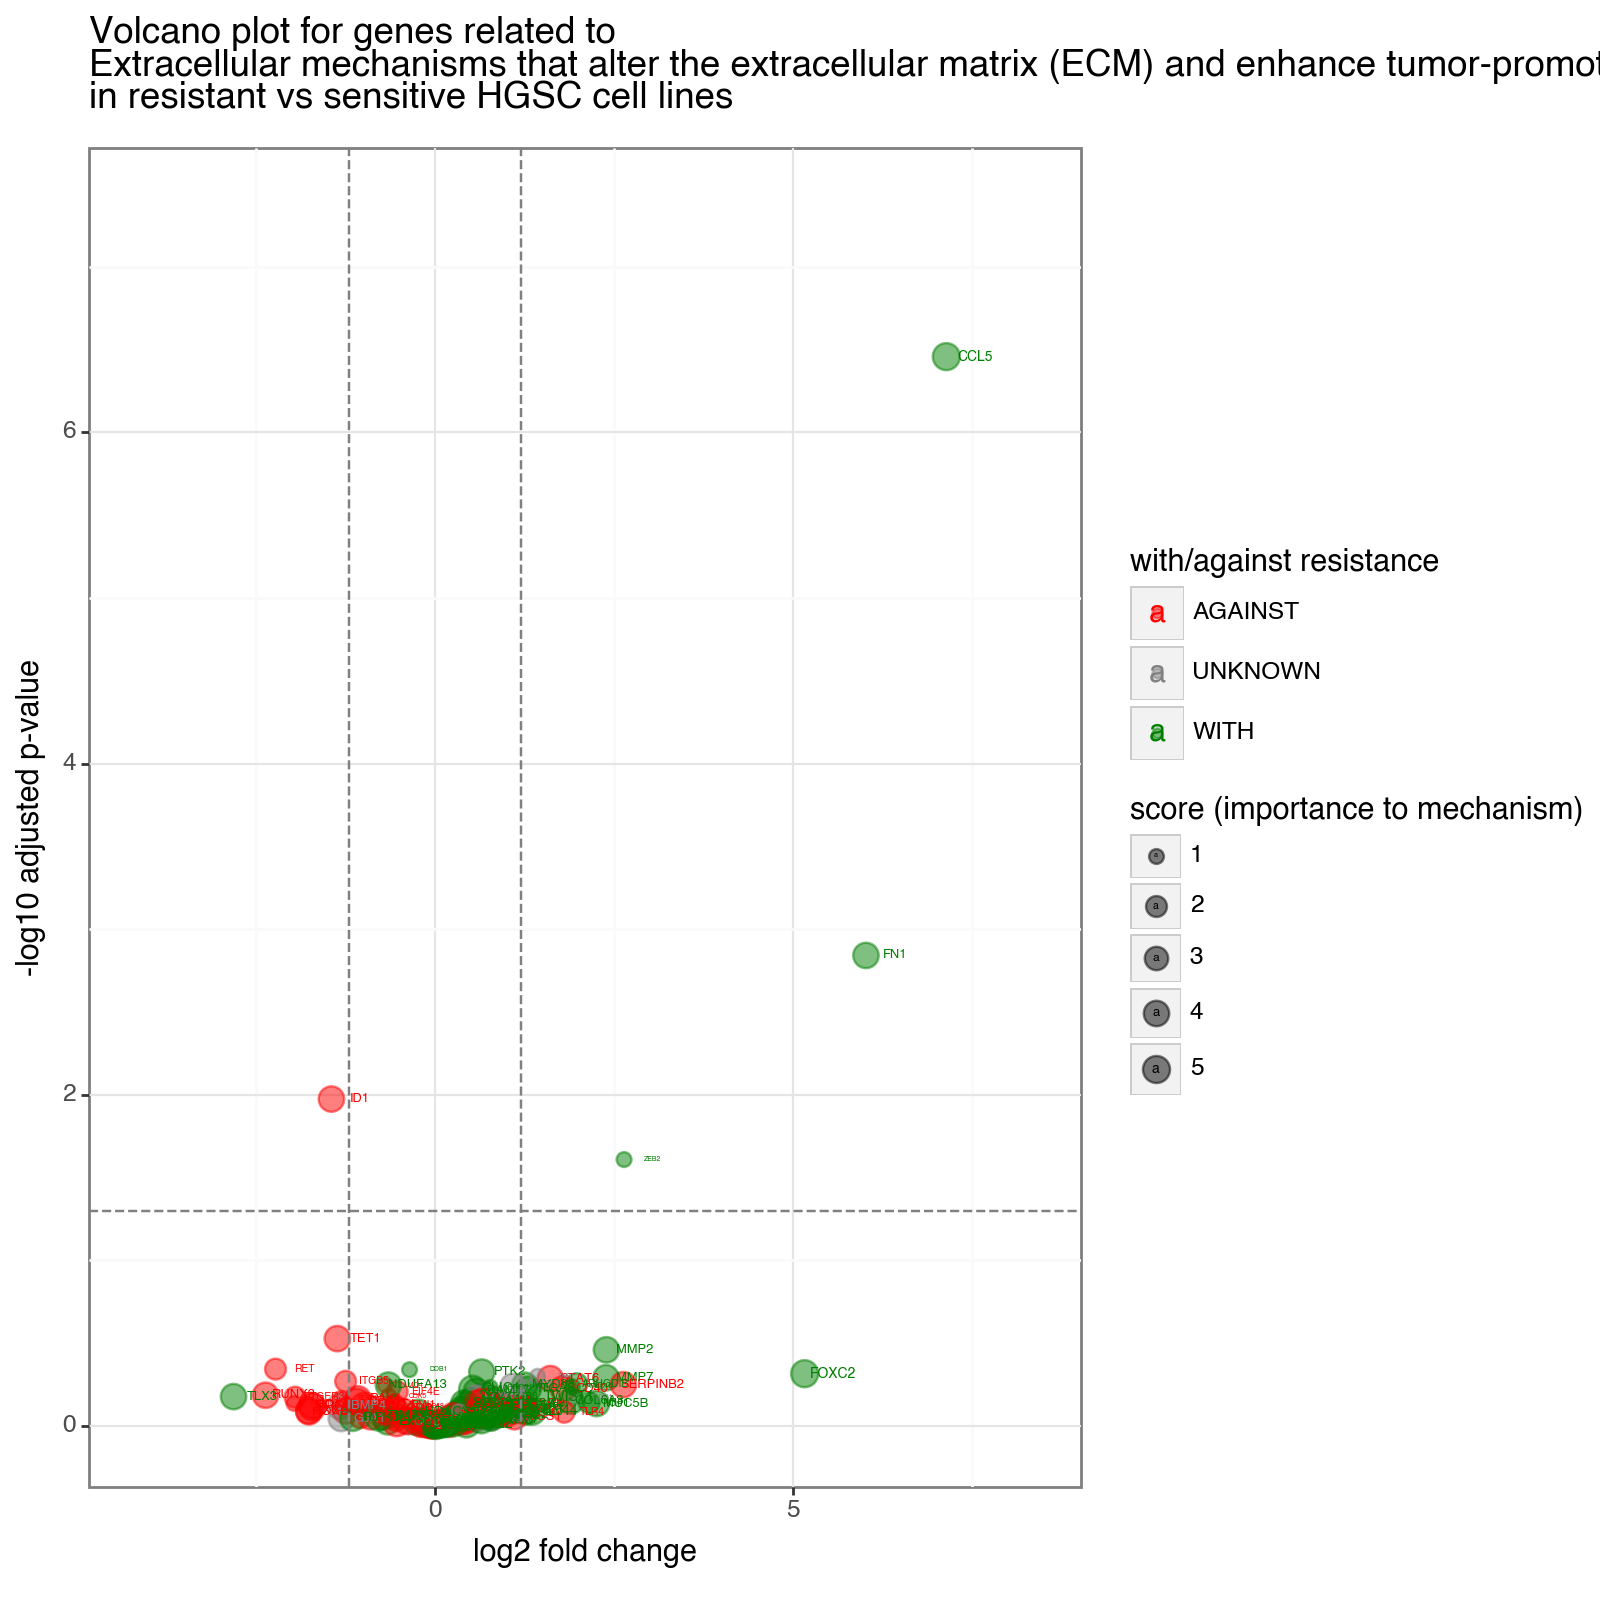

<Figure Size: (800 x 800)>

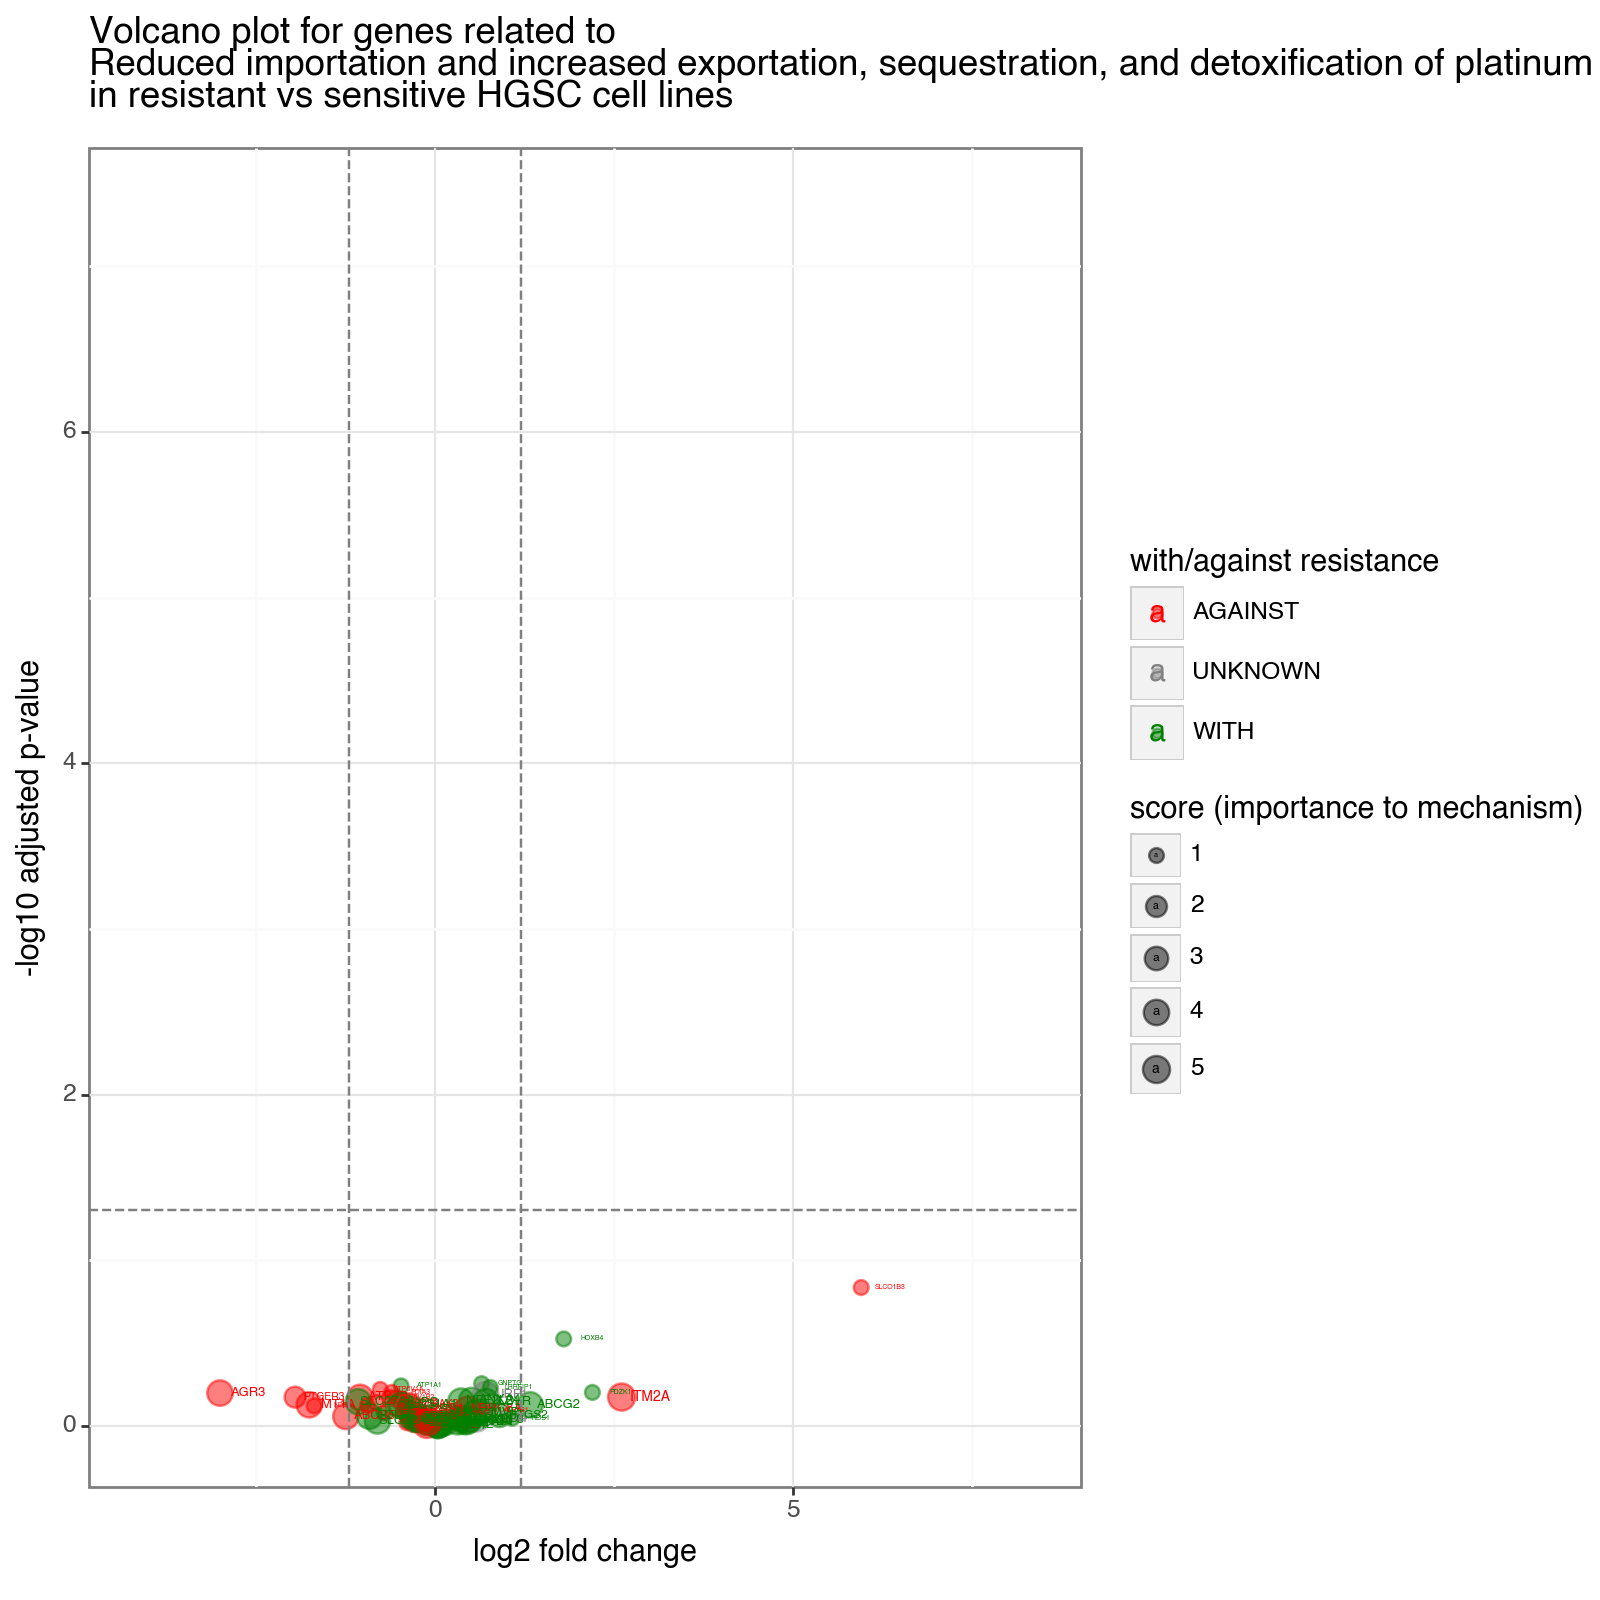

<Figure Size: (800 x 800)>

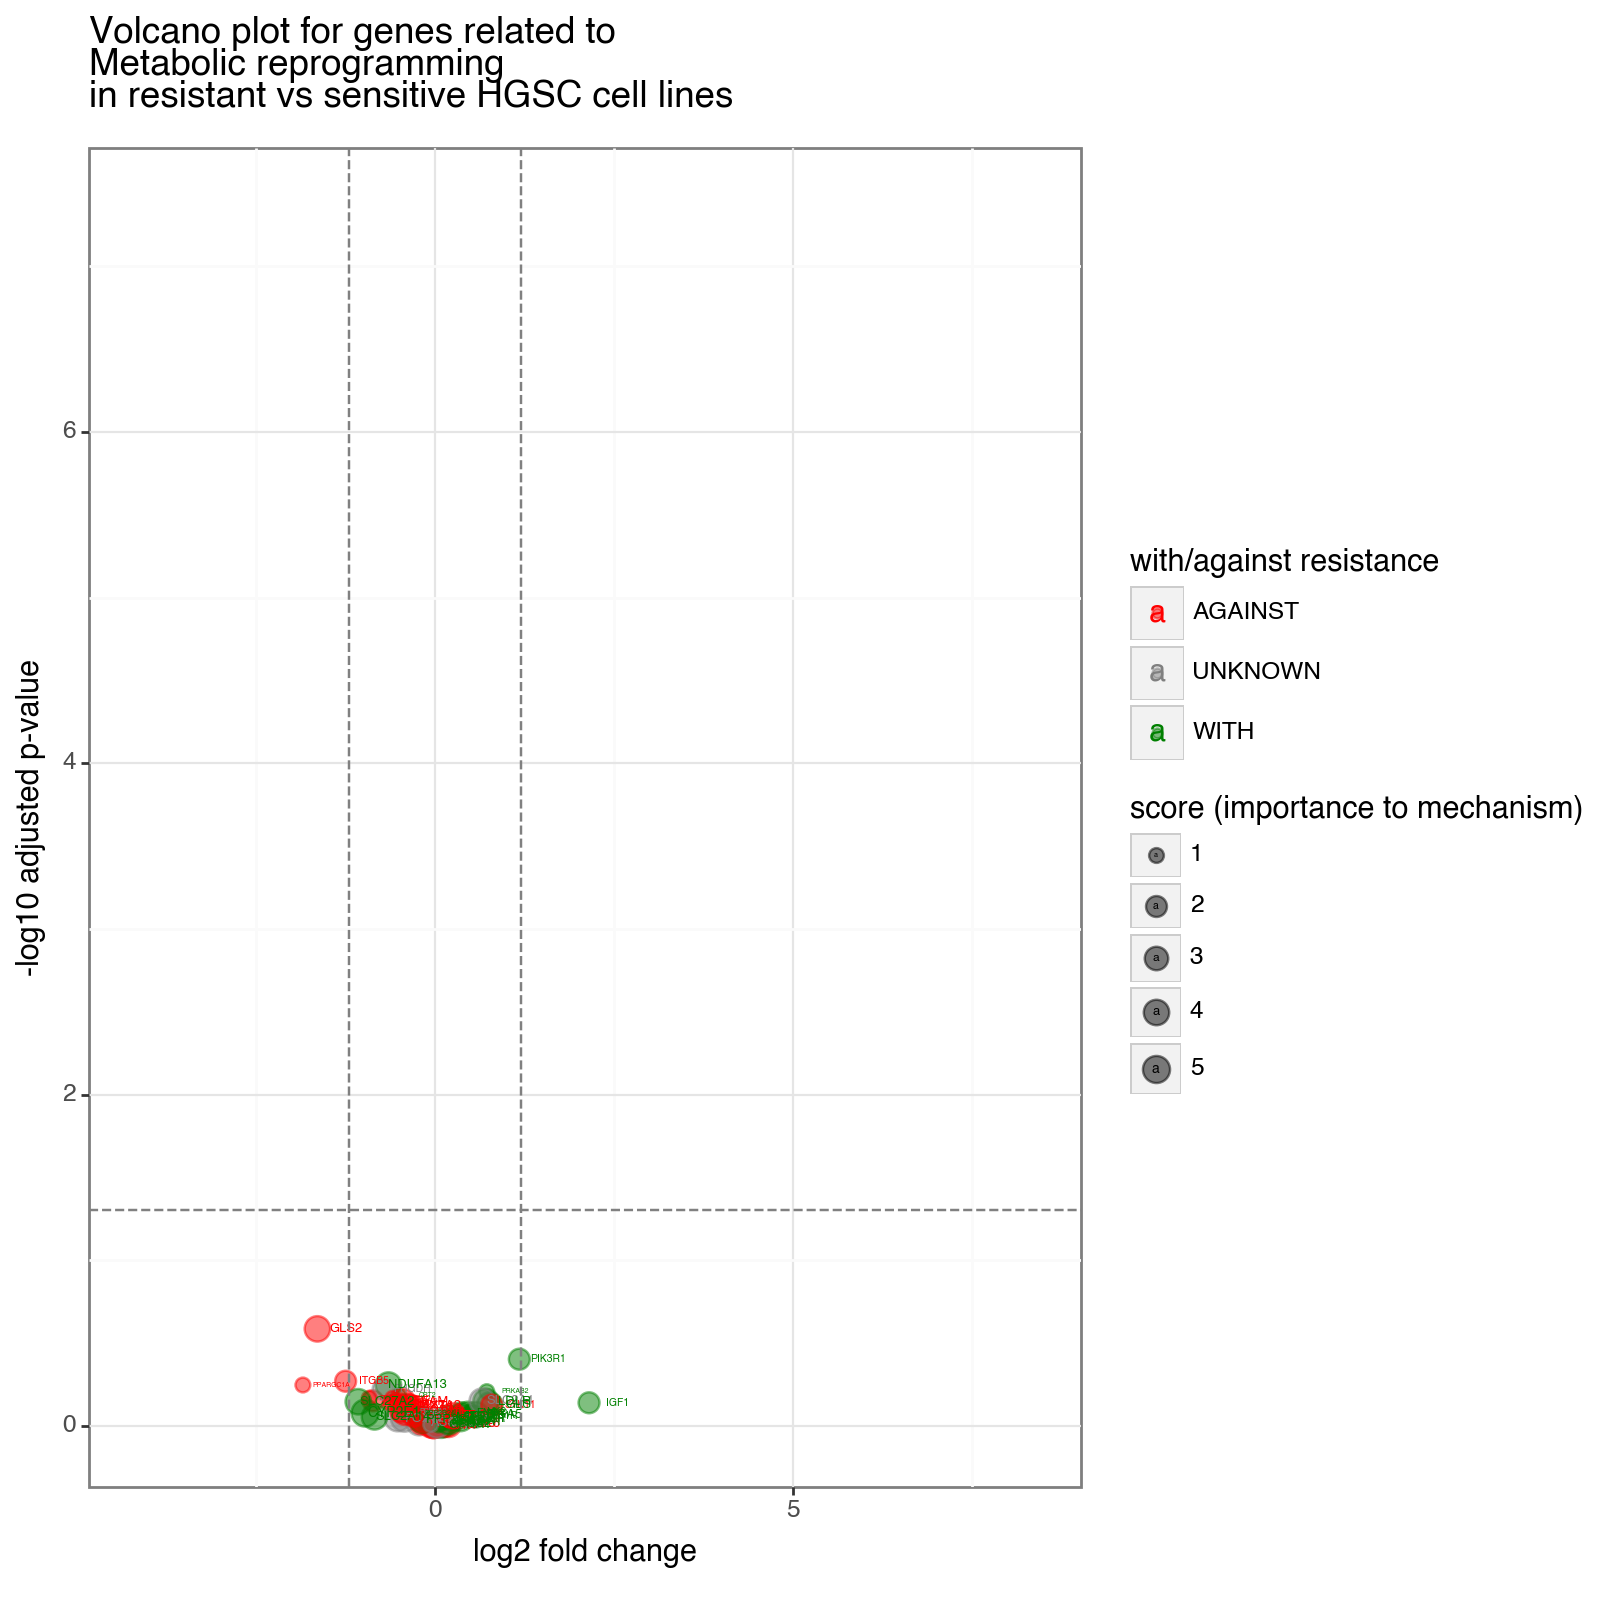

<Figure Size: (800 x 800)>

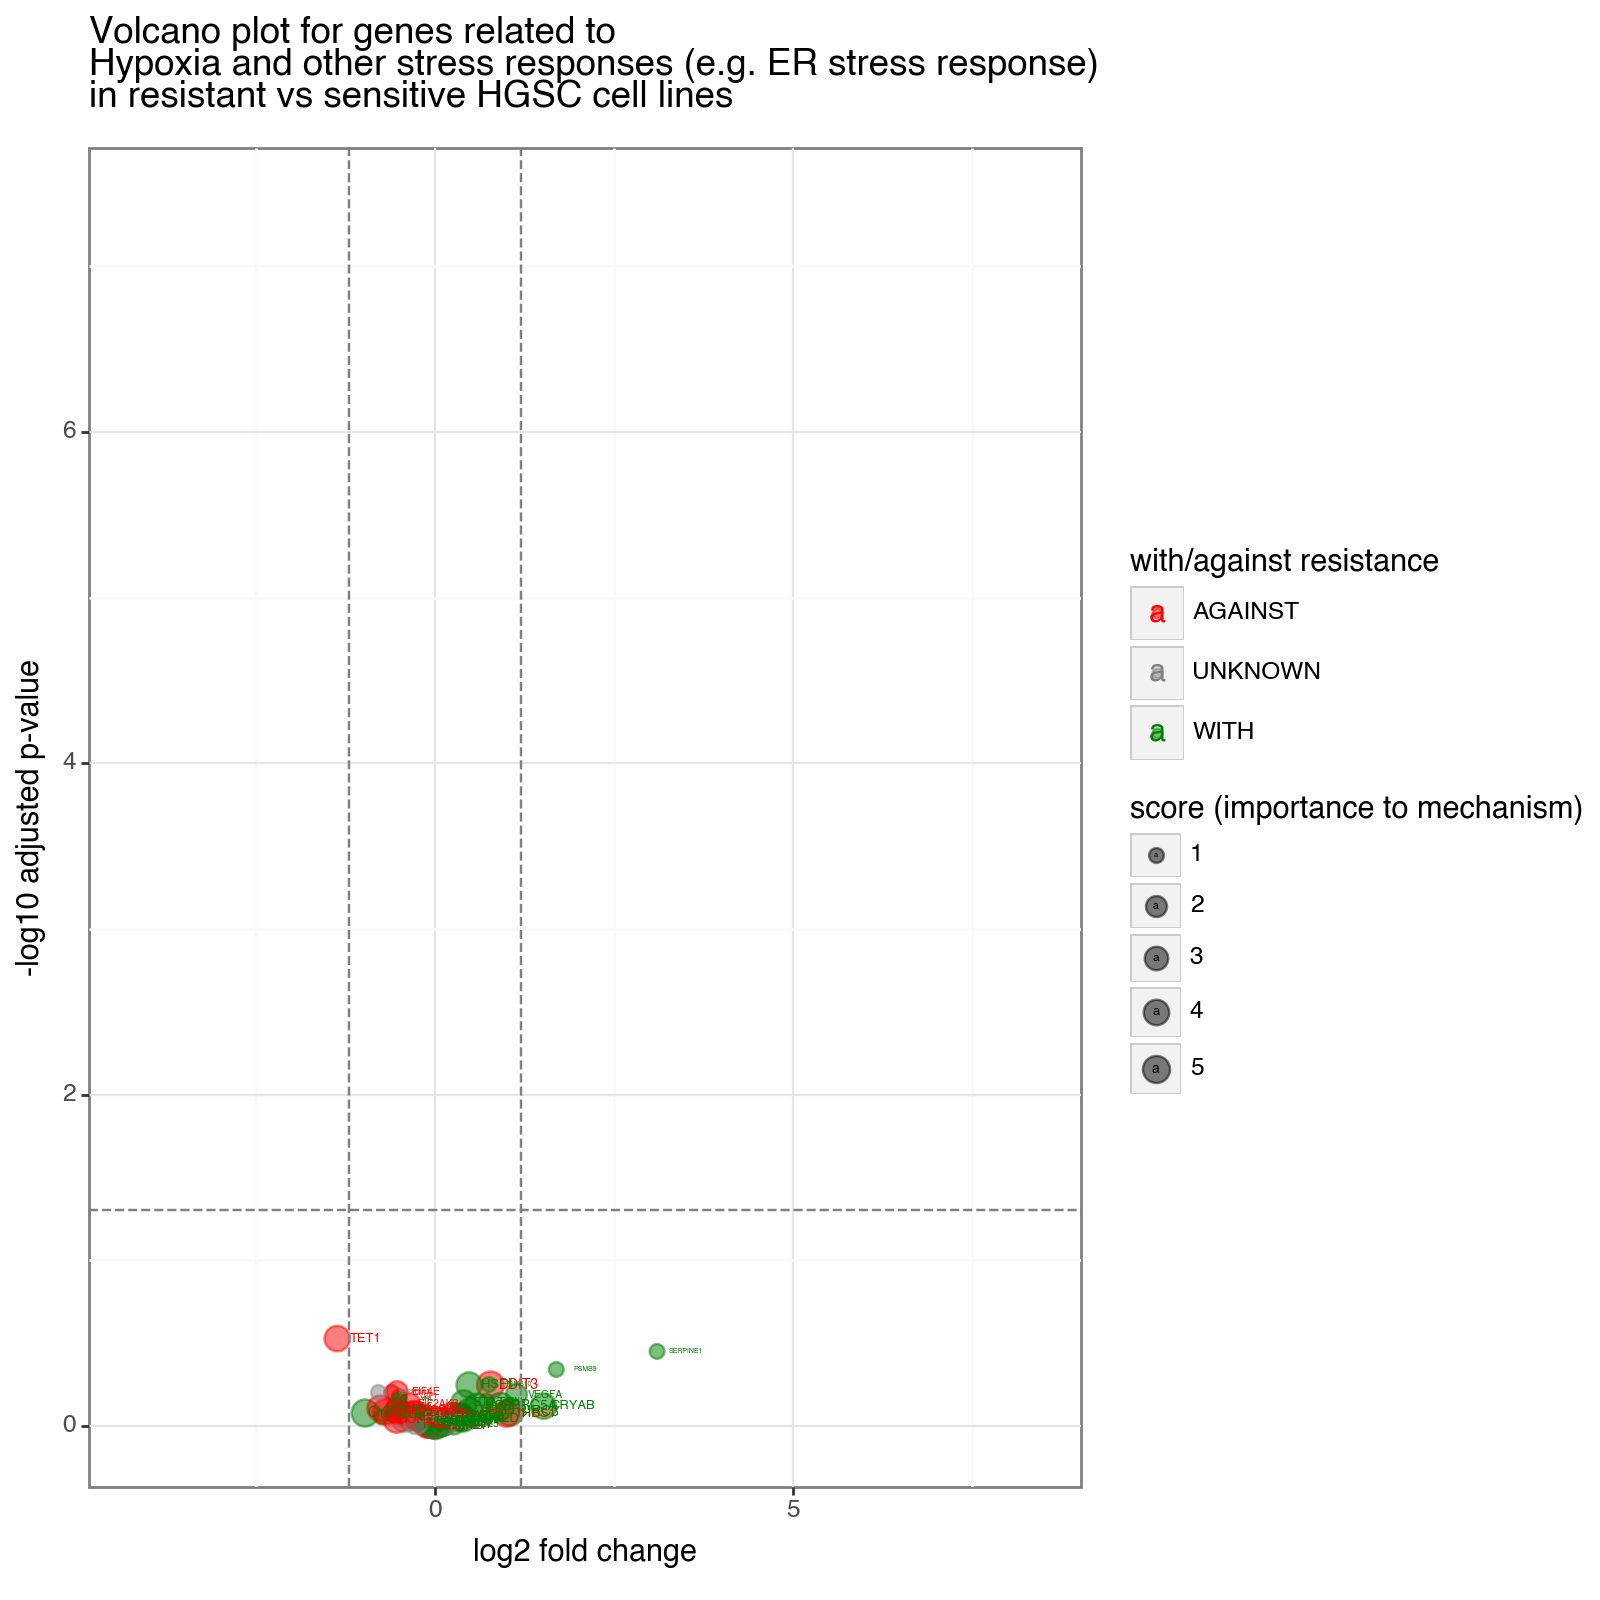

<Figure Size: (800 x 800)>

In [26]:
# Read in deseq data
deseq_df = pd.read_csv(
    differential_rnaseq_file,
    sep=",",
    index_col=0,
)

# Compute x and y limits so that they are consistent across all mechanism groups
relevant_genes = known_mechanisms.gene
plot_limit_data = deseq_df[deseq_df.index.isin(relevant_genes)]
plot_limit_data = plot_limit_data.dropna(subset=["padj", "log2FoldChange"])
plot_limit_data = plot_limit_data[["padj", "log2FoldChange"]]
plot_limit_data["-log10padj"] = -np.log10(plot_limit_data["padj"])
x_min = math.floor(plot_limit_data["log2FoldChange"].min())
x_min = x_min - abs(x_min) * 0.05
x_max = math.ceil(plot_limit_data["log2FoldChange"].max())
x_max = x_max + abs(x_max) * 0.05
y_min = math.floor(plot_limit_data["-log10padj"].min())
y_min = y_min - abs(y_min) * 0.05
y_max = math.ceil(plot_limit_data["-log10padj"].max())
y_max = y_max + abs(y_max) * 0.05

# Plot per group
for group in group_counts_df["group of mechanisms"].tolist():
    volcano_plot_mechanism(group, deseq_df, y_min, y_max, x_min, x_max)